# OpenRAO in pyPowsybl 

In this notebook, you will learn how to use OpenRAO with pypowsybl to optimize a network situation given available remedial actions.

The first step is to install pypowsybl and import the library.

In [1]:
pip install pypowsybl


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pypowsybl as pp

We will consider a 12 bus example network in this notebook.

In [3]:
n12 = pp.network.load('./data/rao/12_node_network.uct')

By drawing the network area diagram, you can get a better understanding of the substations and branches in the network.

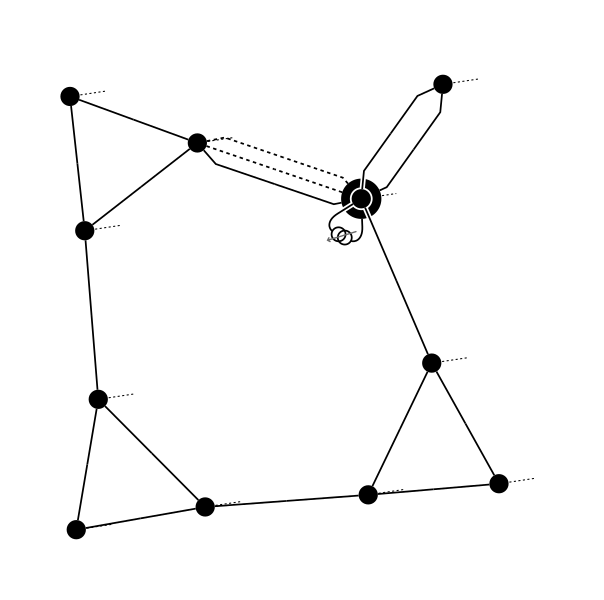

In [4]:
n12.get_network_area_diagram()

## 1 - Simple N case overload

To check the initial situation we can just run a loadflow on the network and redraw the network.

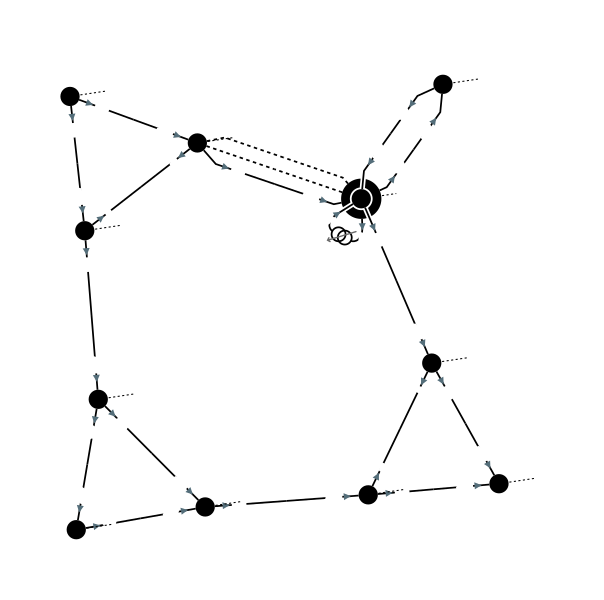

In [5]:
pp.loadflow.run_dc(n12)
n12.get_network_area_diagram()

We can see the initial flow on the line NNL2AA1 and BBE3AA1 is 500MW. However the PATL is only 410 MW so there is an overload on this line.
To solve it we can for instance close one of the other lines between NNL2AA1 and BBE3AA1.

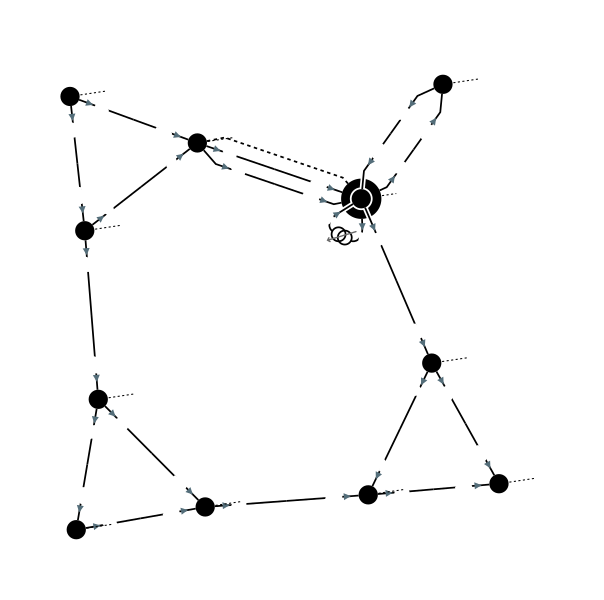

In [6]:
n12.connect("NNL2AA1  BBE3AA1  2")
pp.loadflow.run_dc(n12)
n12.get_network_area_diagram()

As we can see, the new flow is 270MW, and the overload has been solved.

This solution can be found by the RAO. For this we will need some input files: the network (which we already have), and a crac file which will contain information about available remedial actions, and CNECs (critical network elements and contingencies). For more information on the crac input, you can check this page: https://powsybl.readthedocs.io/projects/openrao/en/stable/input-data/crac/json.html

In [12]:
# prepare inputs
n12 = pp.network.load('./data/rao/12_node_network.uct')
rao_runner = pp.rao.create_rao()
rao_runner.set_crac_file_source(n12, "./data/rao/N_case_crac_pst.json")
# set up logging
import logging
logging.getLogger('powsybl').setLevel(logging.INFO)
logging.basicConfig(format='%(asctime)s - %(levelname)s - %(message)s')
#run rao
raoResult = rao_runner.run(n12)
result_json = raoResult.to_json()

2025-02-17 16:31:17,654 - ERROR - BBE1AA1  BBE2AA1  1 - Real line resistance cannot be negative (0.0 ohm)
2025-02-17 16:31:17,655 - ERROR - BBE1AA1  BBE3AA1  1 - Real line resistance cannot be negative (0.0 ohm)
2025-02-17 16:31:17,656 - ERROR - FFR1AA1  FFR2AA1  1 - Real line resistance cannot be negative (0.0 ohm)
2025-02-17 16:31:17,657 - ERROR - FFR1AA1  FFR3AA1  1 - Real line resistance cannot be negative (0.0 ohm)
2025-02-17 16:31:17,658 - ERROR - FFR2AA1  FFR3AA1  1 - Real line resistance cannot be negative (0.0 ohm)
2025-02-17 16:31:17,659 - ERROR - DDE1AA1  DDE2AA1  1 - Real line resistance cannot be negative (0.0 ohm)
2025-02-17 16:31:17,659 - ERROR - DDE1AA1  DDE3AA1  1 - Real line resistance cannot be negative (0.0 ohm)
2025-02-17 16:31:17,660 - ERROR - DDE2AA1  DDE3AA1  1 - Real line resistance cannot be negative (0.0 ohm)
2025-02-17 16:31:17,660 - ERROR - NNL1AA1  NNL2AA1  1 - Real line resistance cannot be negative (0.0 ohm)
2025-02-17 16:31:17,660 - ERROR - NNL1AA1  NNL

Let's examine the results of RAO.

In [8]:
result_json

{'type': 'RAO_RESULT',
 'version': '1.7',
 'info': 'Generated by Open RAO http://farao-community.github.io',
 'computationStatus': 'default',
 'executionDetails': 'The RAO only went through first preventive',
 'costResults': {'initial': {'functionalCost': 90.0,
   'virtualCost': {'sensitivity-failure-cost': 0.0}},
  'preventive': {'functionalCost': -139.73,
   'virtualCost': {'sensitivity-failure-cost': 0.0}},
  'outage': {'functionalCost': -139.73,
   'virtualCost': {'sensitivity-failure-cost': 0.0}},
  'curative': {'functionalCost': -139.73,
   'virtualCost': {'sensitivity-failure-cost': 0.0}}},
 'computationStatusMap': [],
 'flowCnecResults': [{'flowCnecId': 'NNL2AA1  BBE3AA1  1 - preventive',
   'initial': {'ampere': {'margin': -129.99, 'side1': {'flow': 721.77}},
    'megawatt': {'margin': -90.0, 'side1': {'flow': 500.0}}},
   'preventive': {'ampere': {'margin': 201.67, 'side1': {'flow': 390.11}},
    'megawatt': {'margin': 139.73, 'side1': {'flow': 270.27}}}}],
 'angleCnecResults

Now, we can look at the sensitivity matrix, which shows how the active power flow of the two lines changes when the generator's active power changes.

In [9]:
result.get_sensitivity_matrix()

NameError: name 'result' is not defined

An increase of 1 MW on generator `SE_G` has the effect of increasing the active power flow from side 1 to side 2 by 0.26 MW on the lines `S_SO_1` and `S_SO_2`.

## 2 - Zone to zone sensitivity: PTDF computation

This zone-to-zone sensitivity feature is also known as Power Transfer Distribution Factor, or PTDF for short.

Now, imagine that the node `SE`, is in Italy and the other nodes are in France. 
We can update the `TSO` and `country` field of the substations.

In [ ]:
n6b = pp.network.create_metrix_tutorial_six_buses_network()
n6b.update_substations(id=['SE'], TSO=['Terna'], country=['IT'])
n6b.update_substations(id=['NO', 'S', 'SO', 'N'], TSO=['RTE', 'RTE', 'RTE', 'RTE'], country=['FR', 'FR', 'FR', 'FR'])

We can run a load flow:

In [ ]:
pp.loadflow.run_dc(n6b)

In the dataframe with the substation information, the `TSO` and `country` columns are now filled.

In [ ]:
n6b.get_substations()

Now we can create two zones for the sensitivity analysis: one for France and one for Italy:

In [ ]:
zone_fr = pp.sensitivity.create_country_zone(n6b, 'FR')
zone_it = pp.sensitivity.create_country_zone(n6b, 'IT')

We can examine the shift keys for the zone representing France. They're linked to the active power setpoint of the generators:

In [ ]:
zone_fr.shift_keys_by_injections_ids

Let's create the analysis and set the zones to the two we previously declared.

In [ ]:
params = pp.loadflow.Parameters(distributed_slack=False)
sa = pp.sensitivity.create_dc_analysis()
sa.set_zones([zone_fr, zone_it])

And we can create the factor matrix again. This time, we're looking at how changing the net position of the two zones, `FR` and `IT`, affects the active power flow of the lines `S_SE_1` and `S_SE_2`.

In [ ]:
sa.add_branch_flow_factor_matrix(branches_ids=['S_SE_1', 'S_SE_2'], variables_ids=['FR', 'IT'])

We can run the analysis and get the sensitivity matrix.

In [ ]:
ptdf_results = sa.run(n6b, params)
m1 = ptdf_results.get_branch_flows_sensitivity_matrix()
m1

Transferring 1 MW of active power from the zone `FR` to the zone `IT` will cause a 0.3 MW shift on border line `S_SE_1`.

Let’s obtain that directly. After running a sensitivity analysis to figure out the best zones, we can request a `FR` zone to slack sensitivity, a `FR` to `IT` zone to zone sensitivity, an `IT` to `FR` zone to zone sensitivity, and an `IT` zone to slack sensitivity on all the border lines `S_SE_1`, `S_SE_2`, `SE_NE_1` and `SE_NE_2`.

In [ ]:
sa = pp.sensitivity.create_dc_analysis()
sa.set_zones([zone_fr, zone_it])
sa.add_branch_flow_factor_matrix(branches_ids=['S_SE_1', 'S_SE_2', 'SE_NE_1', 'SE_NE_2'], variables_ids=['FR', ('FR', 'IT'), ('IT', 'FR'), 'IT'])
ptdf_result = sa.run(n6b, params)

In [ ]:
m2 = ptdf_result.get_branch_flows_sensitivity_matrix()
m2

We can see that:
- an increase of 1 MW on the `FR` zone net position leads to an increase of 0.2 MW on the flow of all the border lines.
- moving the flow of 1 MW from `FR` to `IT` leads to an increase of 0.3 MW on the flow of lines `S_SE_1` and `S_SE_2` and a decrease of 0.2 MW on the flow of lines `SE_NE_1` and `SE_NE_2`.
- moving the flow of 1 MW from `IT` to `FR` leads to a decrease of 0.3 MW on the flow of lines `S_SE_1` and `S_SE_2` and an increase of 0.2 MW on the flow of lines `SE_NE_1` and `SE_NE_2`.
- an increase of 1 MW on the `IT` zone net position leads to a decrease of 0.1 MW on the flow of lines `S_SE_1` and `S_SE_2` and an increase of 0.4 MW on the flow of lines `SE_NE_1` and `SE_NE_2`.